<a href="https://colab.research.google.com/github/Avani1994/NLP/blob/main/SentimentAnalysisTwitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import keras
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import pickle

import nltk
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
tr = pd.read_csv('/content/drive/MyDrive/TwitterSentimentAnalysis/train.csv')
te = pd.read_csv('/content/drive/MyDrive/TwitterSentimentAnalysis/test.csv')
tr.head()

ytrain = to_categorical(tr['label'])
tweetstrain = list(tr['tweet'])
tweetstest = list(te['tweet'])
tr.head()

print(tr.groupby(['label']).agg(['count']))
te.info()

          id  tweet
       count  count
label              
0      29720  29720
1       2242   2242
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17197 non-null  int64 
 1   tweet   17197 non-null  object
dtypes: int64(1), object(1)
memory usage: 268.8+ KB


In [ ]:
def preprocesstext(line):
  # remove special chars

  line = re.sub(r'[\W+]', ' ', line)

  # remove single chars
  line = re.sub(r'\s+[A-Z][a-z][0-9]\s+', ' ', line)

  #remove single chars from start of line
  line = re.sub(r'^[A-Z][a-z][0-9]\s+', ' ', line)

  #remove multiple spaces
  line = re.sub(r'\s+', ' ', line)

  # lower case
  line = line.lower()

  #split line
  line = line.split(' ')

  # remove stopwords
  line = [word for word in line if word not in stopwords]

  return ' '.join(line)



In [ ]:
# preprocess train and text labels
preprocessedTrain = []
maxLen = float('-inf')
for line in list(tweetstrain):
  preprocessedTrain.append(preprocesstext(line))
  maxLen = max(maxLen, len(line))
preprocessedTest = []
for line in list(tweetstest):
  preprocessedTest.append(preprocesstext(line))


In [ ]:
# Tokenize test and train
tok = Tokenizer()
tok.fit_on_texts(preprocessedTrain)
xtrain = tok.texts_to_sequences(preprocessedTrain)
xtest = tok.texts_to_sequences(preprocessedTest)

xtrain = pad_sequences(xtrain, maxlen = maxLen)
xtest = pad_sequences(xtest, maxlen = maxLen)

vocabSize = len(tok.word_index) + 1


In [ ]:
# get pretrained embedding
embeddingFile = open('/content/drive/MyDrive/glove.6B.100d.txt', encoding='utf8')
embeddingDic = {}
for line in embeddingFile:
  line = line.split()
  word = line[0]
  embedding = np.asarray(line[1:], dtype='float32')
  embeddingDic[word] = embedding

embeddingMatrix = np.zeros((vocabSize, 100))
print(np.shape(embeddingMatrix))
print(vocabSize)
for word, index in tok.word_index.items():
  embedd = embeddingDic.get(word)
  if(embedd is not None):
    embeddingMatrix[index] = embedd

print(embeddingMatrix[0])

(41254, 100)
41254
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
# prepare model with pretrained embedding
model = Sequential()
model.add(Embedding(vocabSize, 100, weights = [embeddingMatrix], trainable = False))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(2, activation='softmax'))
opt = keras.optimizers.Adam()
#keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
model.summary()
hist = model.fit(xtrain,ytrain,batch_size=64,validation_split=0.2,epochs=3,verbose=1,shuffle = True)


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 100)         4125400   
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 256)               234496    
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 514       
Total params: 4,360,410
Trainable params: 235,010
Non-trainable params: 4,125,400
_________________________________________________________________
Epoch 1/3
400/400 [==============================] - 737s 2s/step - loss: 0.1808 - accuracy: 0.9376 - val_loss: 0.1503 - val_accuracy: 0.9453
Epoch 2/3
400/400 [==============================] - 717s 2s/step - loss: 0.1469 - accuracy: 0.9470 - val_loss: 0.1340 - val_accuracy: 0.9515
Epoch 3/3
400/400 [==============================] - 731s 2s/step - loss: 0.1319 - 

In [ ]:
# evaluate on test set
predict = (model.predict(xtest) > 0.5).astype("int32")
print(predict)
loss, acc = model.evaluate(xtest)
print('loss:', loss, 'acc:', acc)



[[0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]
1/1 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
loss: 0.0 acc: 0.0


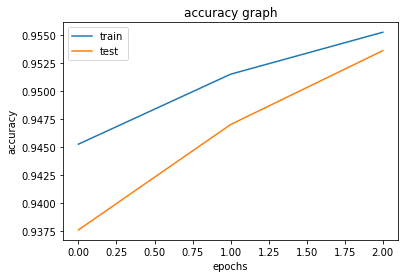

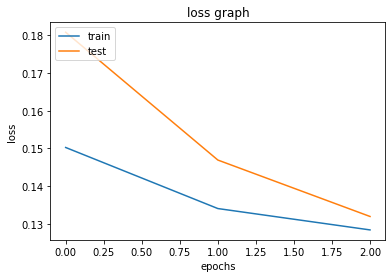

In [ ]:
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy graph')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['val_loss'])
plt.plot(hist.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss graph')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#predict a single tweet
model.save('twitter_sentiments_weights.h5')
pickle.dump(tok, open('tok.pkl', 'wb'))

tw = "83,1,how the #altright uses  &amp; insecurity to lure men into #whitesupremacy"
twpreprocessed = preprocesstext(tw)
print(twpreprocessed)
token = pickle.load(open('tok.pkl', 'rb'))
seq = token.texts_to_sequences([twpreprocessed])
paddedseq = pad_sequences(seq, maxlen = maxLen)
pred = (model.predict(paddedseq) > 0.5).astype('int32')
print(pred)



83 1 altright uses amp insecurity lure men whitesupremacy
[[1 0]]


In [ ]:
# TODO
# Next very bad accuracy because dataset is imbalanced (use techniques to reduce that)
# use precision recall to check accuracy
# prepare model with trainable embedding layer from scratch
